In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
from toy_gpu3_v2 import UniversalGrid

In [3]:
'''
def compute_shape_2D(X0, X1, Sigma, n_sigma, tilt_min, tilt_max):
    """
    Compute the upper and lower bounds of the parallelepiped based on tilt and sigma.
    X0, X1: Tensors defining bounding positions in the X/Y plane. (N, 2), float
    Sigma: (N, 2)
    n_sigma: (2, )
    tilt_min: Scalar tensor indicating tilt value (>0, <0, or 0).
    tilt_max: Scalar
    N_sigma: Scalar tensor for diffusion approximation. (N, 2), float
    return:
    ref : (N, 2) : bottom-left corner; values can be negative
    width : (N, )
    height : (N, )
    tilt : (N, )
    """
    tilt = (X1[:,1]-X0[:,1])/(X1[:,0]-X0[:,0]) # (N,); inf can be in the result

    if not isinstance(n_sigma, torch.Tensor):
        n_sigma = torch.tensor(n_sigma, dtype=torch.float32, requires_grad=False)

    mask = (torch.abs(tilt) < tilt_max) & (torch.abs(tilt) >= tilt_min)
    positive_mask = mask & (tilt >= 0)
    negative_mask = mask & (tilt < 0)
    N_sigma = n_sigma[None,:] * Sigma
    nsx, nsy = [N_sigma[:,i] for i in range(2)] # (N, ), (N, )

    minX0X1 = torch.min(X0, X1) # (N, 2); xmin, ymin
    maxX0X1 = torch.max(X0, X1) # (N, 2)
    height = maxX0X1[:,1] - minX0X1[:,1] + 2 * nsy # (N, )

    dx = 2 * nsy / torch.abs(tilt)

    width = torch.where(
        mask,
        dx + 2 * nsx,
        maxX0X1[:,0] - minX0X1[:,0] + 2 * nsx
    )
    ref = torch.where(
        positive_mask,
        minX0X1 - N_sigma - torch.stack([dx, torch.zeros_like(dx)], dim=1),
        minX0X1 - N_sigma
    )

    return ref, width, height, tilt
'''

def compute_shape_2D(X0, X1, Sigma, n_sigma, tilt_min, tilt_max):
    """
    Compute the upper and lower bounds of the parallelepiped based on tilt and sigma.
    X0, X1: Tensors defining bounding positions in the X/Y plane. (N, 2), float
    Sigma: (N, 2)
    n_sigma: (2, )
    tilt_min: Scalar tensor indicating tilt value (>0, <0, or 0).
    tilt_max: Scalar
    N_sigma: Scalar tensor for diffusion approximation. (N, 2), float
    return:
    ref : (N, 2) : bottom-left corner; values can be negative
    width : (N, )
    height : (N, )
    tilt : (N, )
    """
    tilt = (X1[:,1]-X0[:,1])/(X1[:,0]-X0[:,0]) # (N,); inf can be in the result

    if not isinstance(n_sigma, torch.Tensor):
        n_sigma = torch.tensor(n_sigma, dtype=torch.float32, requires_grad=False)

    mask = (torch.abs(tilt) < tilt_max) & (torch.abs(tilt) >= tilt_min)
    positive_mask = mask & (tilt >= 0)
    negative_mask = mask & (tilt < 0)
    N_sigma = n_sigma[None,:] * Sigma
    nsx, nsy = [N_sigma[:,i] for i in range(2)] # (N, ), (N, )

    minX0X1 = torch.min(X0, X1) # (N, 2); xmin, ymin; tilt > 0 , matched x, y; tilt < 0, mismatched x, y, i.e., (X0[0], X1[1]) or (X0[1], X1[0])
    maxX0X1 = torch.max(X0, X1) # (N, 2);
    width = maxX0X1[:,0] - minX0X1[:,0] + 2 * nsx# (N, )

    dy = 2 * nsx * torch.abs(tilt) # (N,)

    height = torch.where(
        mask,
        dy + 2 * nsy,
        maxX0X1[:,1] - minX0X1[:,1] + 2 * nsy
    )
    ref = torch.where(
        positive_mask,
        minX0X1 - N_sigma - torch.stack([torch.zeros_like(dy), dy], dim=1),
        torch.stack(
            [minX0X1[:,0] - nsx,
             maxX0X1[:,1] - nsy], dim=1
        )
    )
    if torch.sum(~mask).item() > 0:
        ref[~mask] = (minX0X1 - N_sigma)[~mask]
    '''
    print('compute 2d ref.shape', ref.shape)
    print('mask.shape', mask.shape)
    print('positive_mask.shape', positive_mask.shape)
    print('negative_mask.shape', negative_mask.shape)
    print('minX0X1.shape', minX0X1.shape)
    print('maxX0X1.shape', maxX0X1.shape)
    print('N_sigma.shape', N_sigma.shape)
    print('intermediate', (minX0X1 - N_sigma - torch.stack([dy, torch.zeros_like(dy)], dim=1)).shape)
    print('intermediate', (torch.stack(
            [minX0X1[:,0] - nsx[:,None],
             maxX0X1[:,1] - nsy[:,None]], dim=1
        )).shape)
    print('slice', (minX0X1[:,0] - nsx[:,None]).shape)
    print('width.shape', width.shape)
    print('height.shape', height.shape)
    print('tilt.shape', tilt.shape)
    '''

    return ref, width, height, tilt

def compute_shape_2D_stacked(X0, X1, Sigma, n_sigma, tilt_min, tilt_max):
    ref, width, height, tilt = compute_shape_2D(X0, X1, Sigma, n_sigma, tilt_min, tilt_max)
    return torch.stack([ref[:,0], ref[:,1], width, height, tilt], dim=1)

In [4]:
def compute_X0X1_masks(X0, X1, Sigma, n_sigma, origin, grid_spacing, box_offset, box_shape):
    '''
    X0 (N, vdim)
    X1 (N, vdim)
    Sigma (N, vdim)
    n_sigma (vdim,)
    origin (vdim, )
    grid_spacing (vdim, )
    box_offset (N,vdim)
    box_shape (vdim,)
    '''
    if not isinstance(n_sigma, torch.Tensor):
        n_sigma = torch.tensor(n_sigma, dtype=torch.float32, requires_grad=False)
    noff = n_sigma[None, :] * Sigma
    idx0lw = UniversalGrid.compute_index(X0 - noff, origin, grid_spacing) - box_offset # (N, vdim)
    idx0up = UniversalGrid.compute_index(X0 + noff, origin, grid_spacing) - box_offset + 1
    idx1lw = UniversalGrid.compute_index(X1 - noff, origin, grid_spacing) - box_offset
    idx1up = UniversalGrid.compute_index(X1 + noff, origin, grid_spacing) - box_offset + 1

    vdim = len(box_shape)

    # Step 1: Create a grid of indices

    grid_ranges = [torch.arange(s, dtype=torch.long) for s in box_shape]  # Create ranges for each dimension
    grid_mesh = torch.meshgrid(*grid_ranges, indexing='ij')  # Meshgrid of indices
    grid_stack = torch.stack(grid_mesh, dim=-1)  # Shape: (*box_shape, vdim), indices at each grid point

    # Step 2: Compare grid indices with lower and upper edges
    for i in range(vdim):
        idx0lw = idx0lw.unsqueeze(1)
        idx0up = idx0up.unsqueeze(1)
        idx1lw = idx1lw.unsqueeze(1)
        idx1up = idx1up.unsqueeze(1)
    mask0 = (grid_stack.unsqueeze(0) >= idx0lw) & (grid_stack.unsqueeze(0) < idx0up)  # Element-wise comparison
    mask0 = mask0.all(dim=-1)  # Combine comparisons across all dimensions

    mask1 = (grid_stack.unsqueeze(0) >= idx1lw) & (grid_stack.unsqueeze(0) < idx1up)
    mask1 = mask1.all(dim=-1)

    return mask0, mask1



In [5]:
def mask2D(X0, X1, Sigma, n_sigma, tilt_min, tilt_max, origin, grid_spacing, box_offset, box_shape):
    '''
    X0, X1: Tensors defining start/end positions. (N, 2), float
    Sigma: (N, 2)
    n_sigma: (2, )
    tilt_min: axis1 / axis0, Scalar tensor indicating tilt value (>0, <0, or 0).
    tilt_max: Scalar
    N_sigma: Scalar tensor for diffusion approximation. (N, 2), float
    origin : (2,) float
    grid_spacing : (2,) float
    box_offset : (N,2), int
    box_shape : (2,), int
    '''
    # tilt is height / width
    # width maps to x, axis 0
    # height maps to y, axis 1

    ref, width, height, tilt = compute_shape_2D(X0, X1, Sigma, n_sigma, tilt_min, tilt_max)
    start_x, start_y = ref[:,0], ref[:,1]

    # print('ref.shape', ref.shape)
    # print('start_x.shape', start_x.shape)
    # print('start_y.shape', start_y.shape)

    # historical swap...
    cols = torch.arange(box_shape[0], dtype=torch.int32).unsqueeze(1) # (box_width, 1)
    rows = torch.arange(box_shape[1], dtype=torch.int32).unsqueeze(0) # (1, box_height)

    start = torch.stack([start_x, start_y], dim=1) # (N, 2)
    local_startidx = UniversalGrid.compute_index(start, origin, grid_spacing) - box_offset # (N, 2)

    tilt_mask = (torch.abs(tilt) < tilt_max) & (torch.abs(tilt) >= tilt_min)
    print('tilt_mask', tilt_mask.shape)
    print('local_startidx[:,0]', local_startidx[:,0].shape)
    row_offsets_per_col = torch.where(
        tilt_mask[:, None, None],
        torch.clamp((cols.unsqueeze(0) - local_startidx[:,0][:, None, None]) * tilt[:, None, None] , min=0), # shape (N, box_width, 1)
        0
    )
    row_starts_per_col = local_startidx[:,1][:, None, None] + row_offsets_per_col # shape (N, box_width, 1)
    row_ends_per_col = row_starts_per_col + torch.ceil(height[:, None, None]/grid_spacing[1]) + 1 # shape (N, box_width, 1)
    cols = cols.unsqueeze(0)
    rows = rows.unsqueeze(0)
    col_mask = (
        (cols >= local_startidx[:,0][:,None,None])
        & (cols < (local_startidx[:,0] + torch.floor(width/grid_spacing[0]))[:,None,None] + 1)
    ) # (N, box_width, 1)
    # print(rows.shape)
    # print(row_offsets_per_col.shape)
    # print(row_starts_per_col.shape)
    # print(col_mask.shape)
    mask = (
        (rows >= row_starts_per_col) & (rows < row_ends_per_col) & col_mask
    )
    return mask

In [6]:
def plot_mask2D(mask, array_shape, ith, ref_box0, ref_box1):
    # Extract coordinates where the mask is True
    x, y = np.where(mask[ith])
    x0, y0 = np.where(ref_box0[ith])
    x1, y1 = np.where(ref_box1[ith])
    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x0, y0, facecolors='none', edgecolors='red', s=20, label='X0')
    plt.scatter(x1, y1, facecolors='none', edgecolors='orange', s=20, label='X1')
    plt.scatter(x, y, color='blue', marker='o', s=5, label='Parallelogram')

    # plt.gca().invert_yaxis()  # Match array indexing
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(np.arange(0, array_shape[0]))
    plt.yticks(np.arange(0, array_shape[1]))
    plt.title("Mask Visualization with Dots")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

X0 tensor([[0, 1],
        [6, 0]])
X1 tensor([[ 7,  8],
        [ 9, 10]])
tensor([[ -2.0000,  -5.0000],
        [  4.0000, -15.3333]]) tensor([11.,  7.]) tensor([ 8.0000, 17.3333]) tensor([1.0000, 3.3333])
tilt_mask torch.Size([2])
local_startidx[:,0] torch.Size([2])


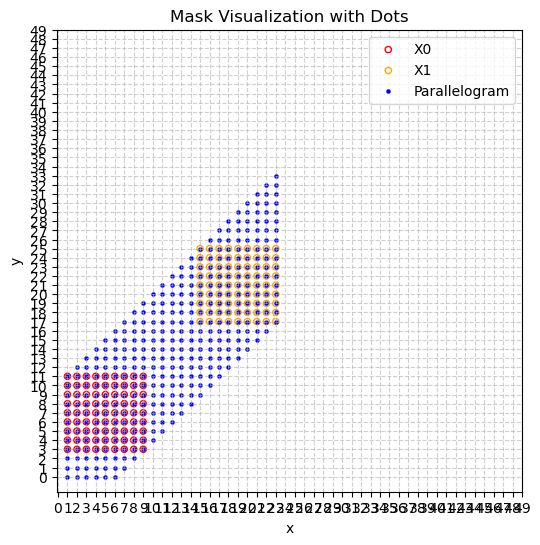

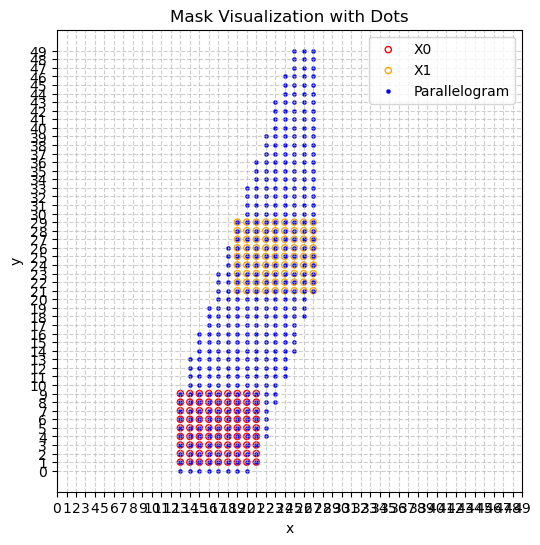

tilt_mask torch.Size([2])
local_startidx[:,0] torch.Size([2])


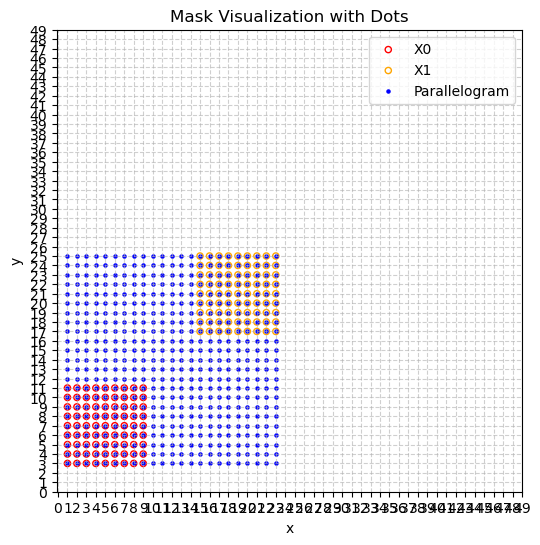

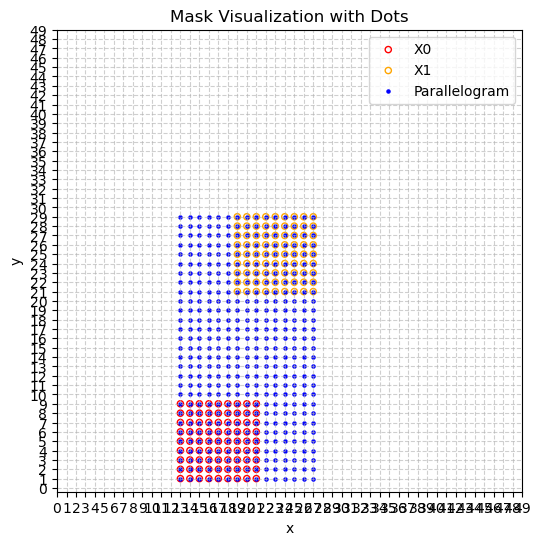

In [7]:
X0 = torch.tensor([[0, 1], [6, 0]])
X1 = torch.arange(7, 11).view(2, 2)
Sigma = torch.ones([2,2])
origin = torch.tensor((0, 0))
grid_spacing = torch.tensor((0.5, 0.5))
box_offset = torch.tensor([[-5,-5], [-5, -5]], dtype=torch.int32)
box_shape = torch.tensor([50, 50], dtype=torch.int32)
n_sigma = (2, 2)
# height = 8 - 1 + 2 * 2 * 1 = 11.0, _
# width = 7/7 * 2 * 2 * 1 + 2 * 2 * 1 =8.0, _
# reference point = (0-2*1-7/7*2*2*1, -1), _ --> (-6.0, -1.0), _
# tilt = (1.0, _)
print('X0', X0)
print('X1', X1)
ref, width, height, tilt = compute_shape_2D(X0, X1, Sigma, n_sigma, 0.01, 1E9)
print(ref, width, height, tilt)
m2ds = mask2D(X0, X1, Sigma, n_sigma, 1E-9, 1E9, origin, grid_spacing, box_offset, box_shape)
mx0, mx1 = compute_X0X1_masks(X0, X1, Sigma, n_sigma, origin, grid_spacing, box_offset, box_shape)
plot_mask2D(m2ds, box_shape, 0, mx0, mx1)
plot_mask2D(m2ds, box_shape, 1, mx0, mx1)

m2ds_rectangle = mask2D(X0, X1, Sigma, n_sigma, 1.5, 1, origin, grid_spacing, box_offset, box_shape)
plot_mask2D(m2ds_rectangle, box_shape, 0, mx0, mx1)
plot_mask2D(m2ds_rectangle, box_shape, 1, mx0, mx1)

In [8]:
def animate_masks(mc, mm, array_shape, axis=0):
    axs = {0, 1, 2}
    axs.remove(axis)
    axs = sorted(list(axs))
    permute_ax = [axis] + axs
    mc = np.transpose(mc, axes=permute_ax)
    # Extract coordinates where the mask is True
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()
    xc, yc = np.where(mc[0])
    scatc = ax.scatter(xc, yc, facecolors='none', edgecolors='red', s=20, label='Charge')
    if mm is not None:
        mm = np.transpose(mm, axes=permute_ax)
        xm, ym = np.where(mm[0])
        statm = ax.scatter(xm, ym, marker='o', s=10, c='blue', label='Mask')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xticks(np.arange(0, array_shape[axs[0]]))
    ax.set_yticks(np.arange(0, array_shape[axs[1]]))
    ax.set_title(f"Parallelepiped Animation Along axis-{ax}: frame 0")
    ax.set_xlabel(f"axis {axs[0]}")
    ax.set_ylabel(f"axis {axs[1]}")
    ax.legend()
    def update(frame):
        xc, yc = np.where(mc[frame])
        scatc.set_offsets(np.c_[xc, yc])
        if mm is not None:
            xm, ym = np.where(mm[frame])
            statm.set_offsets(np.c_[xm, ym])
        ax.set_title(f"Parallelepiped Animation Along axis {axis}, frame {frame}")
        arts = [scatc]
        if mm is not None:
            arts.append(statm)
        return arts

    ani = FuncAnimation(fig, update, frames=range(array_shape[0]), blit=True, interval=1000)
    return ani

In [9]:
def compute_X_masks(X, Sigma, n_sigma, origin, grid_spacing, box_offset, box_shape):
    '''
    X0 (N, vdim)
    X1 (N, vdim)
    Sigma (N, vdim)
    n_sigma (vdim,)
    origin (vdim, )
    grid_spacing (vdim, )
    box_offset (N,vdim)
    box_shape (vdim,)
    '''
    if not isinstance(n_sigma, torch.Tensor):
        n_sigma = torch.tensor(n_sigma, dtype=torch.float32, requires_grad=False)
    print('n_sigma', n_sigma.shape)
    noff = n_sigma[None, :] * Sigma


    vdim = len(box_shape)

    # Step 1: Create a grid of indices
    if not isinstance(grid_spacing, torch.Tensor):
        grid_spacing = torch.tensor(grid_spacing)
    if not isinstance(origin, torch.Tensor):
        origin = torch.tensor(origin)
    if not isinstance(box_offset, torch.Tensor):
        box_offset = torch.tensor(box_offset)
    if not isinstance(box_shape, torch.Tensor):
        box_shape = torch.tensor(box_shape)
    X = X - origin.unsqueeze(0) - box_offset * grid_spacing.unsqueeze(0)
    lengths = box_shape * grid_spacing
    grid_ranges = [torch.linspace(origin[i], lengths[i], box_shape[i]+1) for i in range(len(origin))]
    grid_mesh = torch.meshgrid(*grid_ranges, indexing='ij')
    grid_stack = torch.stack(grid_mesh, dim=-1)
    X0 = X - noff
    X1 = X + noff
    for i in range(vdim):
        X0 = X0.unsqueeze(1)
        X1 = X1.unsqueeze(1)
    mask0 = (grid_stack.unsqueeze(0) >= X0) & (grid_stack.unsqueeze(0) < X1)
    
    # idx0lw = UniversalGrid.compute_index(X - noff, origin, grid_spacing) - box_offset # (N, vdim)
    # idx0up = UniversalGrid.compute_index(X + noff, origin, grid_spacing) - box_offset + 1
    # grid_ranges = [torch.arange(s, dtype=torch.long) for s in box_shape]  # Create ranges for each dimension
    # grid_mesh = torch.meshgrid(*grid_ranges, indexing='ij')  # Meshgrid of indices
    # grid_stack = torch.stack(grid_mesh, dim=-1)  # Shape: (*box_shape, vdim), indices at each grid point
    # Step 2: Compare grid indices with lower and upper edges
    # for i in range(vdim):
    #     idx0lw = idx0lw.unsqueeze(1)
    #     idx0up = idx0up.unsqueeze(1)

    # mask0 = (grid_stack.unsqueeze(0) >= idx0lw) & (grid_stack.unsqueeze(0) < idx0up)  # Element-wise comparison
    # print(mask0.shape)

    
    mask0 = mask0.all(dim=-1)  # Combine comparisons across all dimensions

    return mask0

def stack_X_masks(Xs, Sigmas, n_sigma, origin, grid_spacing, box_offset, box_shape):
    masks = compute_X_masks(Xs, Sigmas, n_sigma, origin, grid_spacing, box_offset, box_shape)
    return torch.any(masks, dim=0)

def compute_Xs(X0, X1, n = 100):
    X0 = torch.tensor(X0)
    X1 = torch.tensor(X1)
    Xs = torch.empty((n, len(X0)))
    for i in range(len(X0)):
        Xs[:,i] = torch.floor(torch.linspace(X0[i], X1[i], n))
    return Xs

In [10]:
def compute_shape_3D(X0, X1, Sigma, n_sigma, ax=(0,1,2), tilt_min=(1E-3,1E-3,1E-3), tilt_max=(1E3,1E3,1E3)):
    '''
    ax : tuple (3, )
    tilt : ax[1]/ax[0], ax[2]/ax[0], ax[2]/ax[1]
    '''
    tilt = torch.stack(
        [ (X1[:,ax[j]]-X0[:,ax[j]])/(X1[:,ax[i]]-X0[:,ax[i]])
                                    for i, j in zip([0, 0, 1], [1, 2, 2])]
    ) # tilt[3] will be recomputed according to the shape; as projection must be larger than the original area
    if not isinstance(n_sigma, torch.Tensor):
        n_sigma = torch.tensor(n_sigma, dtype=torch.float32, requires_grad=False)
    if not isinstance(tilt_min, torch.Tensor):
        tilt_min = torch.tensor(tilt_min, dtype=torch.float32,
                                requires_grad=False, device=X0.device)
    if not isinstance(tilt_max, torch.Tensor):
        tilt_max = torch.tensor(tilt_max, dtype=torch.float32,
                                requires_grad=False, device=X0.device)
    N_sigma = n_sigma[None,:] * Sigma

    condition = X0[:, ax[0]] < X1[:, ax[0]]  # Shape: (N,)
    X0new = torch.where(condition.unsqueeze(1), X0, X1)
    X1new = torch.where(condition.unsqueeze(1), X1, X0)
    mask12 = ( # ax1/ax0, ax2/ax0
            (torch.abs(tilt[0]) < tilt_max[0])  & (torch.abs(tilt[0]) >= tilt_min[0])
            & (torch.abs(tilt[1]) < tilt_max[1])  & (torch.abs(tilt[1]) >= tilt_min[1])
    )
    # for a reasonable tilt[1], tilt[2]
    # dax1 = tilt[1] * N_sigma[:,ax[0]] * 2 # (N, )
    # dax2 = tilt[2] * N_sigma[:,ax[0]] * 2 # (N, )
    dax1 = tilt[0] * N_sigma[:,ax[0]] * 2 # (N, )
    dax2 = tilt[1] * N_sigma[:,ax[0]] * 2 # (N, )
    X0new_ax12 = torch.stack([X0new[:, ax[1]], X0new[:, ax[2]]], dim=1)
    X0new_shift_ax12 = X0new_ax12 - torch.stack([dax1, dax2], dim=1)
    Sigma_ax12 = torch.stack([Sigma[:, ax[1]], Sigma[:, ax[2]]], dim=1)
    n_sigma_ax12 = torch.tensor([n_sigma[ax[1]], n_sigma[ax[2]]])

    X0_ax12 = torch.stack([X0[:, ax[1]], X0[:, ax[2]]], dim=1)
    X1_ax12 = torch.stack([X1[:, ax[1]], X1[:, ax[2]]], dim=1)

    stacked_2Dshape = torch.where(
        mask12[:, None],
        compute_shape_2D_stacked(X0new_shift_ax12, X0new_ax12, Sigma_ax12, n_sigma_ax12, tilt_min[2], tilt_max[2]), # (N, 5)
        compute_shape_2D_stacked(X0_ax12, X1_ax12, Sigma_ax12, n_sigma_ax12, tilt_min[2], tilt_max[2]) # degenerated (N, 5)
    )
    ref_ax12 = stacked_2Dshape[:,:2]
    width_ax12 = stacked_2Dshape[:,2]
    height_ax12 = stacked_2Dshape[:,3]
    tilt_ax12 = stacked_2Dshape[:,4]

    ref_ax0 = X0new[:,ax[0]] - N_sigma[:,ax[0]]
    depth_ax0 = X1new[:,ax[0]]-X0new[:,ax[0]] + 2 * N_sigma[:,ax[0]]
    tilt_ax01 = tilt[0]
    tilt_ax02 = tilt[1]
    # further dealing with degeneracy for tilt_ax00, tilt_ax01 necessary
    # missing tilt ax 12 degenerated?

    # print('ref_ax0', ref_ax0,
    #       'ref_ax12', ref_ax12,
    #       'depth_ax0', depth_ax0,
    #       'width_ax12', width_ax12,
    #       'height_ax12', height_ax12,
    #       'tilt_ax01', tilt_ax01,
    #       'tilt_ax02', tilt_ax02,
    #       'tilt_ax12', tilt_ax12)

    return ref_ax0, ref_ax12, depth_ax0, width_ax12, height_ax12, tilt_ax01, tilt_ax02, tilt_ax12


In [11]:
def mask3D(X0, X1, Sigma, n_sigma, tilt_min, tilt_max, origin, grid_spacing, box_offset, box_shape, **kwargs):
    '''
    X0, X1: Tensors defining start/end positions. (N, 3), float
    Sigma: (N, 3)
    n_sigma: (3, )
    tilt_min: min of ax[1]/ax[0], ax[2]/ax[0], ax[2]/ax[1], tuple
    tilt_max: min of ax[1]/ax[0], ax[2]/ax[0], ax[2]/ax[1], tuple
    origin : (3,) float
    grid_spacing : (3,) float
    box_offset : (N, 3), int, in grid indexing
    box_shape : (3,), int, range of array indexing

    kwargs['ax'] = (0, 1, 2) or others
    '''
    # tilt is height / width
    # width maps to x, axis 0
    # height maps to y, axis 1
    ax = kwargs.get('ax', (0, 1, 2))
    # ax0, ax[0], is just from min to max
    # ax1, ax[1], is controlled by ax0
    # ax2, ax[2], is controlled by ax0 and ax1
    idxax0 = torch.arange(box_shape[ax[0]], dtype=torch.int32).unsqueeze(1).unsqueeze(2) # (box_depth, 1, 1)
    idxax1 = torch.arange(box_shape[ax[1]], dtype=torch.int32).unsqueeze(0).unsqueeze(2) # (1, box_width, 1)
    idxax2 = torch.arange(box_shape[ax[2]], dtype=torch.int32).unsqueeze(0).unsqueeze(1) # (1, 1, box_height)

    tilt_min_ax01 = torch.tensor(tilt_min[0], dtype=torch.float32, requires_grad=False, device=X0.device)
    tilt_min_ax02 = torch.tensor(tilt_min[1], dtype=torch.float32, requires_grad=False, device=X0.device)
    tilt_min_ax12 = torch.tensor(tilt_min[2], dtype=torch.float32, requires_grad=False, device=X0.device)

    tilt_max_ax01 = torch.tensor(tilt_max[0], dtype=torch.float32, requires_grad=False, device=X0.device)
    tilt_max_ax02 = torch.tensor(tilt_max[1], dtype=torch.float32, requires_grad=False, device=X0.device)
    tilt_max_ax12 = torch.tensor(tilt_max[2], dtype=torch.float32, requires_grad=False, device=X0.device)

    ref_ax0, ref_ax12, depth_ax0, width_ax12, height_ax12, tilt_ax01, tilt_ax02, tilt_ax12 = compute_shape_3D(X0, X1, Sigma, n_sigma, ax, tilt_min, tilt_max)
    start = [ref_ax0, ref_ax12[:,0], ref_ax12[:,1]] # (N, 3)
    start = torch.stack([x for _, x in sorted(zip(ax, start))], dim=1)
    # print('testing start sorted', ax[0], ax[1], ax[2])
    # print('testing start sorted', ref_ax0, ref_ax12[:,0], ref_ax12[:,1])
    # print('testing start sorted', start)

    local_array_startidx = UniversalGrid.compute_index(start, origin, grid_spacing) - box_offset # (N, 3) # array indices
    print('testing start sorted', local_array_startidx)

    tilt_mask12 = ( # ax1/ax0, ax2/ax0
            (torch.abs(tilt_ax01) < tilt_max_ax01)  & (torch.abs(tilt_ax01) >= tilt_min_ax01)
            & (torch.abs(tilt_ax02) < tilt_max_ax02)  & (torch.abs(tilt_ax02) >= tilt_min_ax02)
    ) # (N, )
    tilt_mask_ax12 = (
        (torch.abs(tilt_ax12) < tilt_max_ax12) & (torch.abs(tilt_ax12) >= tilt_min_ax12)
    )

    # dax0 * tilt01 = dax1
    # dax0 * tilt01 = dax2
    # dax1 * tilt12 = dax2
    
    idxax1_offset_per_ax0 = torch.where(tilt_mask12[:, None, None, None],  # (N, 1, 1, 1)
                                        torch.clamp(tilt_ax01[:,None, None, None] *  (idxax0.unsqueeze(0) - local_array_startidx[:,ax[0]][:, None, None, None]),
                                                    min=0) # (N, 1, 1, 1) * {(1, box_depth, 1, 1) - (N, 1, 1, 1)} --> (N, box_depth, 1, 1)
                                        , 0) # (N, box_depth, 1, 1)

    idxax2_offset_per_ax0_ax1 = torch.where(tilt_mask_ax12[:, None, None, None], # (N, 1, 1, 1)
                                            torch.clamp(
                                            #     tilt_ax01[:,None, None, None] * (idxax0.unsqueeze(0) - local_array_startidx[:,ax[0]][:, None, None, None]) # (N, 1, 1, 1) * {(1, box_depth, 1, 1) - (N, 1, 1, 1)} --> (N, box_depth, 1, 1),
                                            # +
                                            tilt_ax12[:,None, None, None] * (idxax1.unsqueeze(0) - local_array_startidx[:,ax[1]][:, None, None, None]) # (N, 1, 1, 1) * {(1, 1, box_width, 1) - (N, 1, 1, 1)} --> (N, 1, box_width, 1)
                                            , min=0), 0) # --> (N, box_depth, box_width, 1)

    idxax1_start_per_ax0 = local_array_startidx[:,ax[1]][:, None, None, None] + idxax1_offset_per_ax0 # (N, 1, 1, 1) + (N, box_depth, 1, 1) --> (N, box_depth, 1, 1)
    idxax1_start_per_ax0 = idxax1_start_per_ax0.clamp(min=0, max=box_shape[ax[1]]-1) # (N, box_depth, 1, 1)

    idxax2_start_per_ax0_ax1 = local_array_startidx[:,ax[2]][:, None, None, None] + idxax2_offset_per_ax0_ax1 # (N, 1, 1, 1) + (N, box_depth, box_width, 1) --> (N, box_depth, box_width, 1)
    idxax2_start_per_ax0_ax1 = idxax2_start_per_ax0_ax1.clamp(min=0, max=box_shape[ax[2]]-1) # (N, box_depth, box_width, 1)
    idxax2_start_per_ax0_ax1 = torch.floor(idxax2_start_per_ax0_ax1)

    idxax1_end_per_ax0 = idxax1_start_per_ax0 + torch.ceil(width_ax12[:, None, None, None]/grid_spacing[ax[1]]) + 1 + 1 # (N, box_depth, 1, 1) + (N, 1, 1, 1) --> (N, box_depth, 1, 1)
    idxax2_end_per_ax0_ax1 = idxax2_start_per_ax0_ax1 + torch.ceil(height_ax12[:, None, None, None]/grid_spacing[ax[2]]) + 1 + 1# ((N, box_depth, box_width, 1) + (N, 1, 1, 1) --> (N, box_depth, box_width, 1)

    # TBD; another reference
    (_, ref_ax21, _,
     width_ax21, height_ax21, _, _, 
     _) = compute_shape_3D(X0, X1, Sigma, n_sigma,
                                                (ax[0], ax[2], ax[1]), 
                                                (tilt_min[0], tilt_min[2], tilt_min[1]),
                                                (tilt_max[0], tilt_max[2], tilt_max[1]))

    idxax2_offset_per_ax0 = torch.where(
        tilt_mask12[:, None, None, None],
        torch.clamp(tilt_ax02[:,None, None, None] * (idxax0.unsqueeze(0) - local_array_startidx[:,ax[0]][:, None, None, None]) # (N, 1, 1, 1) * {(1, box_depth, 1, 1) - (N, 1, 1, 1)} --> (N, box_depth, 1, 1)
        , min=0),
        0
    ) # (N, box_depth, 1, 1)
    
    # TBD; another reference
    start_ax21 = [ref_ax0, ref_ax21[:,0], ref_ax21[:,1]] # (N, 3)
    start_ax21 = torch.stack([x for _, x in sorted(zip([ax[0], ax[2], ax[1]], start_ax21))], dim=1)
    local_array_startidx_ax21 = UniversalGrid.compute_index(start_ax21, origin, grid_spacing) - box_offset # (N, 3) # array indices
    # print('testing start sorted', ax[0], ax[2], ax[1])
    # print('testing start sorted', ref_ax0, ref_ax21[:,0], ref_ax21[:,1])
    # print('testing start sorted', start_ax21)

    idxax2_start_per_ax0 = local_array_startidx_ax21[:, ax[2]][:,None,None,None] + idxax2_offset_per_ax0
    idxax2_start_per_ax0 = idxax2_start_per_ax0.clamp(min=0, max=box_shape[ax[2]]-1) # (N, box_depth, 1, 1)
    idxax2_end_per_ax0 = idxax2_start_per_ax0 + torch.ceil(width_ax21[:, None, None, None]/grid_spacing[ax[2]]) + 1 +1 # (N, box_depth, 1, box_depth)

    idxax0 = idxax0.unsqueeze(0)
    idxax1 = idxax1.unsqueeze(0)
    idxax2 = idxax2.unsqueeze(0)

    if not isinstance(n_sigma, torch.Tensor):
        n_sigma = torch.tensor(n_sigma)
    minX0X1 = torch.min(X0, X1) - n_sigma.unsqueeze(0) * Sigma
    maxX0X1 = torch.max(X0, X1) + n_sigma.unsqueeze(0) * Sigma
    idxlw = UniversalGrid.compute_index(minX0X1, origin, grid_spacing) - box_offset
    idxup = UniversalGrid.compute_index(maxX0X1, origin, grid_spacing) - box_offset + 1
    
    idxax0_mask = (
        (idxax0 >= local_array_startidx[:,ax[0]][:, None, None, None]) # (N, box_depth, 1, 1)
        & (idxax0 < (torch.ceil(depth_ax0/grid_spacing[ax[0]]) + local_array_startidx[:,ax[0]] + 2)[:, None, None, None]) # (N, box_depth, 1, 1)

    )
    idxax1_mask = (
        (idxax1 >= torch.floor(idxax1_start_per_ax0)) # (1, 1, box_width, 1) >= (N, box_depth, 1, 1) --> (N, box_depth, box_width, 1)
        & (idxax1 < idxax1_end_per_ax0 + 1) # (1, 1, box_width, 1) < (N, box_depth, 1, 1) --> (N, box_depth, box_width, 1)
        & (idxax1 >= idxlw[:,1][:, None, None, None])
        & (idxax1 < idxup[:,1][:, None, None, None])
    )
    idxax2_mask = (
        (idxax2 >= idxax2_start_per_ax0_ax1) # (1, 1, box_height) >= (N, box_depth, box_width, 1) --> (N, box_depth, box_width, box_height)
        & (idxax2 < idxax2_end_per_ax0_ax1 + 1) # (1, 1, box_height) >= (N, box_depth, box_width, 1) --> (N, box_depth, box_width, box_height)
        & (idxax2 >= idxax2_start_per_ax0)
        & (idxax2 < idxax2_end_per_ax0 + 1)
        & (idxax2 >= idxlw[:,2][:, None, None, None])
        & (idxax2 < idxup[:,2][:, None, None, None])
    )
    mask = (
        idxax0_mask & idxax1_mask & idxax2_mask
    )
    # print(tilt_ax01, tilt_ax02, tilt_ax12)
    # print(idxax2_offset_per_ax0_ax1[0])
    # print(idxax2_start_per_ax0_ax1[0])
    return mask


In [12]:
X0 = torch.tensor([[1., 0., 3.], [6., 0., 2.]])
X1 = torch.arange(8., 8.+6).view(2, 3)
print(X0, X1)
Sigma = torch.ones([2,3])
n_sigma = (1, 1, 1)
tilt_min = (1E-3, 1E-3, 1E-3)
tilt_max = (1E3, 1E3, 1E3)
origin = (0, 0, 0)
grid_spacing = (0.5, 0.5, 0.5)
box_offset = torch.tensor([[-5,-5, -5], [-5, -5, -5]], dtype=torch.int32)
box_shape = (40, 45, 50)
m3Dparallel = mask3D(X0, X1, Sigma, n_sigma, tilt_min, tilt_max, origin, grid_spacing, box_offset, box_shape, ax=(0,1,2))

Xs = compute_Xs(X0[0], X1[0], n=100)
Sigmas = torch.tensor(tuple([1,1,1] for _ in range(len(Xs))))
m3D = stack_X_masks(Xs, Sigmas, n_sigma, origin, grid_spacing, box_offset[0], box_shape)
# m3D = compute_X_masks(Xs, Sigmas, n_sigma, origin, grid_spacing, box_offset, box_shape)

tensor([[1., 0., 3.],
        [6., 0., 2.]]) tensor([[ 8.,  9., 10.],
        [11., 12., 13.]])
testing start sorted tensor([[ 5, -3,  1],
        [15, -7, -6]])
n_sigma torch.Size([3])


/var/folders/8q/p_7h_t9d7199sjgc1ftrbs280000gq/T/ipykernel_8132/3925433308.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X0 = torch.tensor(X0)
/var/folders/8q/p_7h_t9d7199sjgc1ftrbs280000gq/T/ipykernel_8132/3925433308.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X1 = torch.tensor(X1)


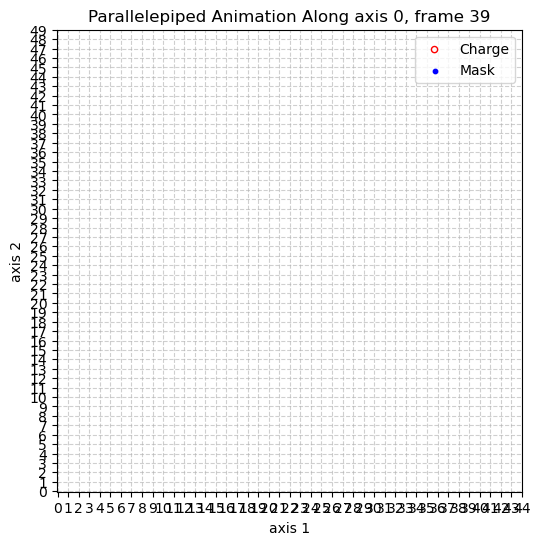

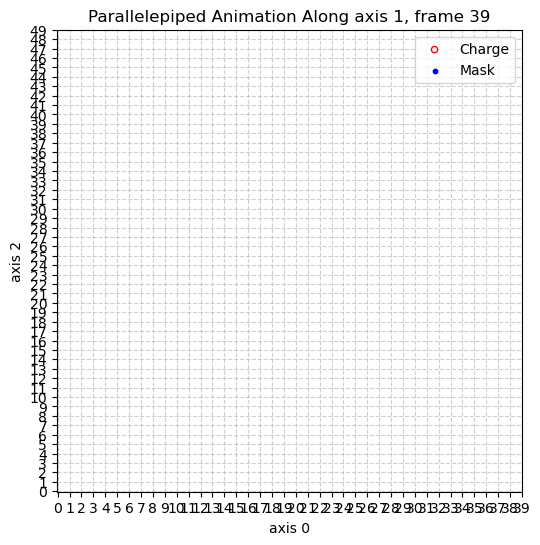

In [13]:
ani0v3 = animate_masks(m3D, m3Dparallel[0], box_shape, axis=0)
ani1v3 = animate_masks(m3D, m3Dparallel[0], box_shape, axis=1)
ani0v3.save('ani0_12.gif')
ani1v3.save('ani1_02.gif')
HTML(ani1v3.to_jshtml())

torch.Size([2, 2, 2, 3])
tensor(2.5714) tensor(2.)
torch.Size([2, 2, 100, 3])
calculation of tilt0, tilt1 - direction[1]/direction[0], direction[2]/direction[0] tensor([0.]) tensor([0.])
ref_ax0 tensor([0.]) depth tensor([9.])
coord of bottom tensor(0.)
difference of coord between bottom and top tensor(2.)
reference point, under ax (0, 1, 2) is tensor(0.) tensor(-3.5714) tensor(-1.5556)
tilt_ax12 tensor([0.7778])


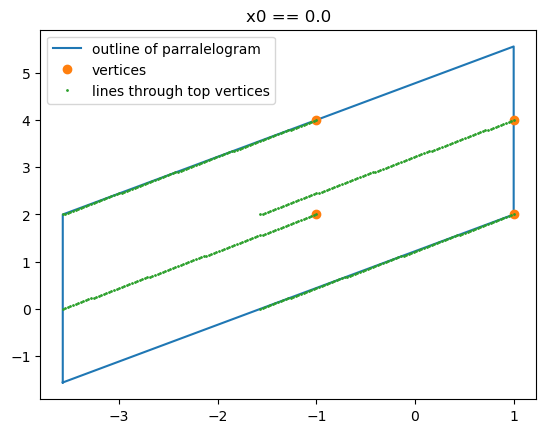

In [14]:
def eight_vertices(center, a, b, c):
    vertices = torch.empty((8,3)).view(2,2,2,3)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                vertices[i,j,k] = center + torch.tensor(
                    [(-1)**(i+1) * a,
                    (-1)**(j+1) * b,
                    (-1)**(k+1) * c]
                )
    return vertices
def throughgoing_lines_on12(vertices, direction, n=100):
    print(vertices.shape)
    d = (vertices[1,0,0,0] - vertices[0,0,0,0])
    d1 = d * direction[1]/direction[0]
    d2 = d * direction[2]/direction[0]
    print(d1, d2)
    l = torch.empty((2,2,n,3))
    for i in range(2):
        for j in range(2):
            l[i,j] = torch.stack(
                   [torch.linspace(vertices[0,i,j,0], vertices[0,i,j,1], n),
            torch.linspace(vertices[0,i,j,1] - d1, vertices[0,i,j,1], n),
            torch.linspace(vertices[0,i,j,2] - d2, vertices[0,i,j,2], n)]
                , dim = 1
            )
    print(l.shape)
    return l
    
def test_compute_shape_3D(X0, X1, Sigma, ax = (0,1,2)):
    if X0 is None:
        X0 = torch.tensor([1.,0.,0.]).view(1,3)
    if X1 is None:
        X1 = torch.tensor([3.,4.,1.]).view(1,3)
    if Sigma is None:
        Sigma = torch.tensor([1,1,1]).view(1,3)
    n_sigma = torch.tensor([1,1,1])
    direction = (X1-X0)/torch.linalg.norm(X1-X0)
    
    N_sigma = n_sigma.view(1,3) * Sigma
    (ref_ax0, ref_ax12, depth_ax0, width_ax12, 
     height_ax12, tilt_ax01, tilt_ax02, tilt_ax12 ) = compute_shape_3D(X0, X1, Sigma, n_sigma, ax=ax)
    
    X0 = X0[:, ax]
    N_sigma = N_sigma[:, ax]
    direction = direction[:, ax]
    
    vertices = eight_vertices(X0, N_sigma[0,0], N_sigma[0,1], N_sigma[0,2])
    # print(vertices)

    # print(vertices[0,:,:,0])
    lines = throughgoing_lines_on12(vertices, direction.view(3))

    xparallelogram = [
        ref_ax12[0,0], ref_ax12[0,0], ref_ax12[0,0]+width_ax12[0], ref_ax12[0,0]+width_ax12[0], ref_ax12[0,0]
    ]
    yparallelogram = [
        ref_ax12[0,1], ref_ax12[0,1]+height_ax12[0], 
        ref_ax12[0,1]+height_ax12[0]+width_ax12[0]*tilt_ax12[0], 
        ref_ax12[0,1]+width_ax12[0]*tilt_ax12[0], ref_ax12[0,1]
    ]
    
    plt.title(f'x{ax[0]} == {vertices[0,0,0,0]}')

    plt.plot(xparallelogram, yparallelogram, '-', markersize=20, label='outline of parralelogram')

    plt.plot(vertices[0,:,:,1].view(4), vertices[0,:,:,2].view(4), 'o', label='vertices')
    plt.plot(lines[:,:,:,1].view(-1), lines[:,:,:,2].view(-1), 'o', markersize=1, label='lines through top vertices')
    # plt.plot(vertices[1,:,:,1].view(4), vertices[1,:,:,2].view(4), 'o')

    plt.legend()
    print('calculation of tilt0, tilt1 - direction[1]/direction[0], direction[2]/direction[0]', 
         tilt_ax01 - direction[0,1]/direction[0,0], tilt_ax02 - direction[0,2]/direction[0,0] )
    print('ref_ax0', ref_ax0, 'depth', depth_ax0)
    print('coord of bottom', vertices[0,0,0,0])
    print('difference of coord between bottom and top', vertices[1,0,0,0] - vertices[0,0,0,0])
    print('reference point, under ax', ax, 'is', ref_ax0[0], ref_ax12[0,0], ref_ax12[0,1])
    print('tilt_ax12', tilt_ax12)

test_compute_shape_3D(X0[0].view(1,3), X1[0].view(1,3), Sigma[0].view(1,3), ax=(0,1,2))